<a href="https://colab.research.google.com/github/ratmcu/bois/blob/master/bois.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import os
import shutil
if os.path.exists('Selfie_Filters_OpenCV') :
    shutil.rmtree('Selfie_Filters_OpenCV')
!git clone https://github.com/ratmcu/Selfie_Filters_OpenCV.git
# !conda env create -f path/to/environment.yml
!export PYTHONPATH=$PYTHONPATH:'Selfie_Filters_OpenCV'
sys.path.append('Selfie_Filters_OpenCV')
# !python test_image.py
from my_CNN_model import *
import cv2
import numpy as np
import math

Cloning into 'Selfie_Filters_OpenCV'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 67 (delta 3), reused 8 (delta 3), pack-reused 56
Unpacking objects: 100% (67/67), done.


Using TensorFlow backend.


W0618 01:13:22.445171 140373306787712 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0618 01:13:22.486925 140373306787712 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0618 01:13:22.494156 140373306787712 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0618 01:13:22.522451 140373306787712 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0618 01:13:22.541601 140373306787712 deprecation_wrapp

-1.0135534594498505 1 [(65.32904, 34.635105), (30.208933, 34.01377), (59.138054, 35.682434), (71.92381, 35.59566), (36.580093, 35.356728), (23.673996, 35.12544), (55.682613, 27.350286), (78.20737, 27.818394), (40.332806, 27.245619), (17.883595, 27.308846), (46.975025, 55.492615), (60.45536, 72.4522), (33.849415, 71.394135), (47.00346, 68.82608), (47.070297, 77.66855)]
[[ 0.99984354 -0.01768892  1.73100221]
 [ 0.01768892  0.99984354 -1.70064873]]
10.139574975896858 2 [(64.66629, 35.09621), (31.348793, 41.054707), (57.781425, 36.571617), (72.35416, 35.51157), (37.051056, 40.624428), (23.132774, 42.005516), (52.826256, 29.417292), (76.85916, 25.94155), (36.795326, 31.2821), (16.319862, 35.91618), (47.837788, 54.924065), (69.04055, 71.53905), (37.488277, 76.36332), (51.47039, 71.79889), (52.506733, 77.271576)]
[[  0.98438182   0.17604669 -15.56156556]
 [ -0.17604669   0.98438182  18.59149307]]


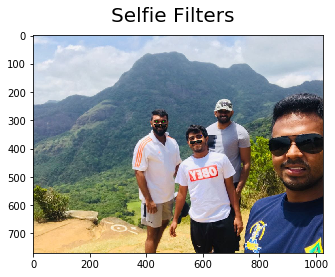

In [2]:
from my_CNN_model import *
import cv2
import numpy as np

# Load the model built in the previous step
my_model = load_my_CNN_model('Selfie_Filters_OpenCV/my_model')

# Face cascade to detect faces
face_cascade = cv2.CascadeClassifier('Selfie_Filters_OpenCV/'+'cascades/haarcascade_frontalface_default.xml')

# Define the upper and lower boundaries for a color to be considered "Blue"
blueLower = np.array([100, 60, 60])
blueUpper = np.array([140, 255, 255])

# Define a 5x5 kernel for erosion and dilation
kernel = np.ones((5, 5), np.uint8)

# Define filters
filters = ['images/sunglasses.png', 'images/sunglasses_2.png', 'images/sunglasses_3.jpg', 'images/sunglasses_4.png', 'images/sunglasses_5.jpg', 'images/sunglasses_6.png']
filters = ['Selfie_Filters_OpenCV/'+filter for filter in filters]
filterIndex = 0

# Load the video
# camera = cv2.VideoCapture(0)
import matplotlib.pyplot as plt
import random
import pylab

figure = pylab.figure()
figure.suptitle('Selfie Filters', fontsize=20)
# Keep looping
while True:
    # Grab the current paintWindow
#     (grabbed, frame) = camera.read()
    frame = cv2.imread("Selfie_Filters_OpenCV/images/bois.jpeg")
#     frame = cv2.imread("fn3.jpg")
    img_bg = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.flip(frame, 1)
    img_bg = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame2 = np.copy(frame)
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Add the 'Next Filter' button to the frame
    frame = cv2.rectangle(frame, (500,10), (620,65), (235,50,50), -1)
    cv2.putText(frame, "NEXT FILTER", (512, 37), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.25, 6)

#     Determine which pixels fall within the blue boundaries and then blur the binary image
#     blueMask = cv2.inRange(hsv, blueLower, blueUpper)
#     blueMask = cv2.erode(blueMask, kernel, iterations=2)
#     blueMask = cv2.morphologyEx(blueMask, cv2.MORPH_OPEN, kernel)
#     blueMask = cv2.dilate(blueMask, kernel, iterations=1)

    # Find contours (bottle cap in my case) in the image
#     (_, cnts, _) = cv2.findContours(blueMask.copy(), cv2.RETR_EXTERNAL,
#     	cv2.CHAIN_APPROX_SIMPLE)
#     center = None

#     Check to see if any contours were found
#     if len(cnts) > 0:
#     	# Sort the contours and find the largest one -- we
#     	# will assume this contour correspondes to the area of the bottle cap
#         cnt = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
#         # Get the radius of the enclosing circle around the found contour
#         ((x, y), radius) = cv2.minEnclosingCircle(cnt)
#         # Draw the circle around the contour
#         cv2.circle(frame, (int(x), int(y)), int(radius), (0, 255, 255), 2)
#         # Get the moments to calculate the center of the contour (in this case Circle)
#         M = cv2.moments(cnt)
#         center = (int(M['m10'] / M['m00']), int(M['m01'] / M['m00']))

#         if center[1] <= 65:
#             if 500 <= center[0] <= 620: # Next Filter
#                 filterIndex += 1
#                 filterIndex %= 6
#                 continue
    face_id = 1
    for (x, y, w, h) in faces:

        # Grab the face
        gray_face = gray[y:y+h, x:x+w]
        color_face = frame[y:y+h, x:x+w]

        # Normalize to match the input format of the model - Range of pixel to [0, 1]
        gray_normalized = gray_face / 255

        # Resize it to 96x96 to match the input format of the model
        original_shape = gray_face.shape # A Copy for future reference
        face_resized = cv2.resize(gray_normalized, (96, 96), interpolation = cv2.INTER_AREA)
        face_resized_copy = face_resized.copy()
        face_resized = face_resized.reshape(1, 96, 96, 1)

        # Predicting the keypoints using the model
        keypoints = my_model.predict(face_resized)

        # De-Normalize the keypoints values
        keypoints = keypoints * 48 + 48

        # Map the Keypoints back to the original image
        face_resized_color = cv2.resize(color_face, (96, 96), interpolation = cv2.INTER_AREA)
        face_resized_color2 = np.copy(face_resized_color)

        # Pair them together
        points = []
        for i, co in enumerate(keypoints[0][0::2]):
            points.append((co, keypoints[0][1::2][i]))

        # Add FILTER to the frame
        sunglasses = cv2.imread(filters[filterIndex], cv2.IMREAD_UNCHANGED)
        
#         sunglass_width = int((points[7][0]-points[9][0])*1.1)
#         sunglass_height = int((points[10][1]-points[8][1])/1.1)
#         sunglass_resized = cv2.resize(sunglasses, (sunglass_width, sunglass_height), interpolation = cv2.INTER_CUBIC)
        angle = -(math.atan((points[1][1]-points[0][1])/(points[1][0]-points[0][0]))*(180))/math.pi
        print(angle, face_id, points)
        
        rows, cols, channels = sunglasses.shape

#         M = cv2.getRotationMatrix2D((cols/2,rows/2), angle,1.1)
#         sunglass_resized = cv2.warpAffine(sunglass_resized,M,(cols,rows))
        hyp = math.sqrt(rows*rows + cols*cols)/2
        top = int(hyp-rows/2)  # shape[0] = rows
        bottom = top
        left = int(hyp-cols/2)  # shape[1] = cols
        right = left
        value = [0, 0, 0]
        borderType = cv2.BORDER_CONSTANT
        sunglass_resized = cv2.copyMakeBorder(sunglasses, top, bottom, left, right, borderType, None, value)
        
        rowsl,colsl,channels = sunglass_resized.shape
#         img = cv2.imread('drawing.png')
#         rows,cols,ch = img.shape

#         pts1 = np.float32([[40,30],[140,30],[90,30]]) # singlass eyes
#         pts2 = np.float32([[10,100],[200,50],[100,250]]) #detecteed eyes

#         M = cv2.getAffineTransform(pts1,pts2)
# 
#         dst = cv2.warpAffine(img,M,(cols,rows))
        M = cv2.getRotationMatrix2D((colsl/2,rowsl/2), angle,1)
        print(M)
        sunglass_resized = cv2.warpAffine(sunglass_resized, M, (colsl, rowsl))
        sunglass_width = int((points[7][0]-points[9][0])*1.1)
        sunglass_height = int((points[10][1]-points[8][1])/0.5)
#         sunglass_resized = cv2.resize(sunglasses, (sunglass_width, sunglass_height), interpolation = cv2.INTER_CUBIC)
        
        sunglass_resized = cv2.resize(sunglass_resized, (sunglass_width, sunglass_height), interpolation = cv2.INTER_CUBIC)

#         sunglass_resized = cv2.resize(sunglasses, (sunglass_width, sunglass_height), interpolation = cv2.INTER_CUBIC)
        transparent_region = sunglass_resized[:,:,:3] != 0
        #adding the sunglasses to the face
#         if face_id == 2:
        face_resized_color[int(points[9][1]):int(points[9][1])+sunglass_height, 
                           int(points[9][0]):int(points[9][0])+sunglass_width,:][transparent_region] = sunglass_resized[:,:,:3][transparent_region]

        # Resize the face_resized_color image back to its original shape
        face_resized_color = cv2.cvtColor(face_resized_color, cv2.COLOR_BGR2RGB)
        img_bg[y:y+h, x:x+w] = cv2.resize(face_resized_color, original_shape, interpolation = cv2.INTER_CUBIC)
#         img_bg[y:y+h, x:x+w] = cv2.resize(face_resized_color, original_shape, interpolation = cv2.INTER_CUBIC)

        # Add KEYPOINTS to the frame2
#         for keypoint in points:
#             cv2.circle(face_resized_color, keypoint, 1, (0,255,0), 1)
        cv2.circle(face_resized_color, points[0], 1, (0,255,0), 1) #right eye
        cv2.circle(face_resized_color, points[1], 1, (0,255,0), 1) #left eye
        
        cv2.circle(face_resized_color, points[7], 1, (0,0,255), 1) #left eye
        cv2.circle(face_resized_color, points[9], 1, (0,0,255), 1) #right eye

        cv2.circle(face_resized_color, points[9], 1, (0,0,255), 1) #right eye
        cv2.circle(face_resized_color, points[9], 1, (0,0,255), 1) #right eye


#         frame2[y:y+h, x:x+w] = cv2.resize(face_resized_color2, original_shape, interpolation = cv2.INTER_CUBIC)
#         if face_id == 1:
        img_bg[y:y+h, x:x+w] = cv2.resize(face_resized_color, original_shape, interpolation = cv2.INTER_CUBIC)
        face_id = face_id + 1
        # Show the frame and the frame2
#         cv2.imshow("Selfie Filters", frame)
#         cv2.imshow("Facial Keypoints", frame2)
        
        # plt.subplot(121)
#         pylab.imshow(frame)
        
    # If the 'q' key is pressed, stop the loop
    break
#     if cv2.waitKey(1) & 0xFF == ord("q"):
#         break
pylab.imshow(img_bg)
pylab.show()
# Cleanup the camera and close any open windows
# camera.release()
# cv2.destroyAllWindows()
